### Dataset Import and Inspection

In [44]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
# print(heart_disease.metadata)

# variable information
pd.DataFrame(heart_disease.variables)

X = heart_disease.data.features
y = heart_disease.data.targets

# Convert to dataframe
df = pd.concat([X, y], axis=1)

# Inspect data
df.head()
df.info() # ca and thal have null values
df.isna().sum()
(df == '?').sum() # no ? values
(df == 0).sum()

# ca and thal should not have 0 values (but they do)
# ca: number of major vessels (can't be 0)
# thal: thalassemia type (3 is normal, it can't be 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


age           0
sex          97
cp            0
trestbps      0
chol          0
fbs         258
restecg     151
thalach       0
exang       204
oldpeak      99
slope         0
ca          176
thal          0
num         164
dtype: int64

###

### Data Cleanup

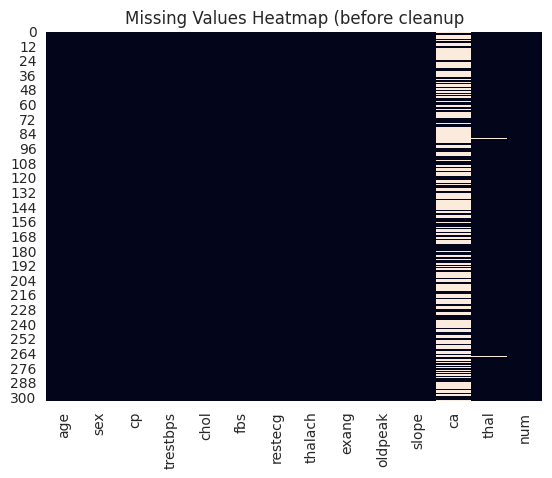

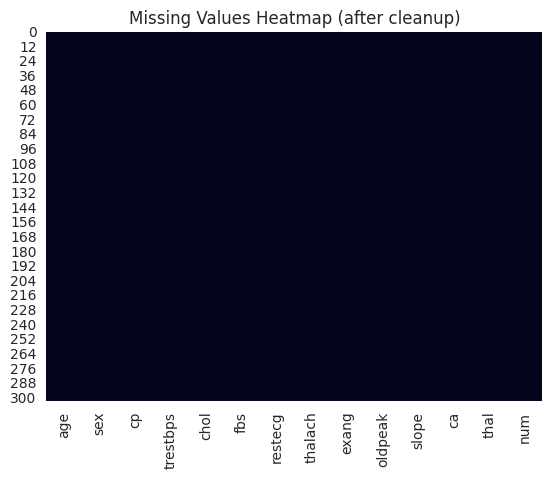

In [24]:
cols_w_invalid_zero = ['ca', 'thal']

# Convert 0's to NaN
for col in cols_w_invalid_zero:
    df[col] = df[col].replace(0,np.nan)

# Check if zeros are gone
(df == 0).sum()

sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (before cleanup")
plt.show()

# ca and thal have NaN values

# convert zero values of the numerical feature ca to median
median_val = pd.to_numeric(df['ca'], errors='coerce').median()
df['ca'] = df['ca'].fillna(median_val)

# convert zero values of the categorical feature thal to mode (most frequent category)
mode_val = df['thal'].mode()[0]
df['thal'] = df['thal'].fillna(median_val)

# Check if there are missing values after cleanup
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (after cleanup)")
plt.show()



### Check for class imbalance

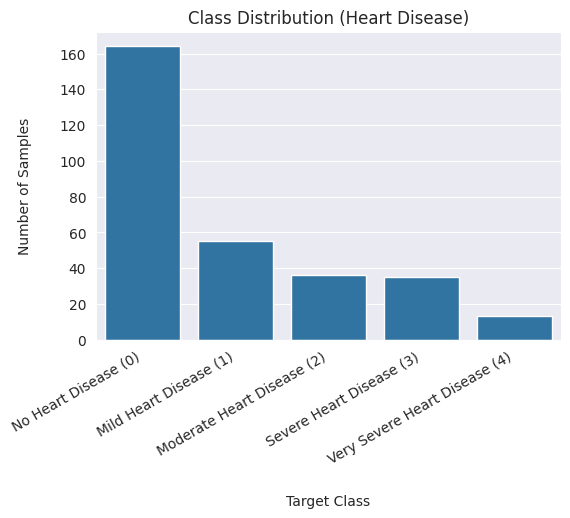

Class counts:
 num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Class proportions:
 num
0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: count, dtype: float64


In [25]:

# Count target classes
class_counts = df['num'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values
)

plt.xlabel('Target Class', labelpad=20)
plt.ylabel('Number of Samples', labelpad=20)
plt.title('Class Distribution (Heart Disease)')
plt.xticks(rotation=30, ha='right')
plt.xticks([0, 1, 2, 3, 4], ['No Heart Disease (0)', 'Mild Heart Disease (1)', 'Moderate Heart Disease (2)', 'Severe Heart Disease (3)', 'Very Severe Heart Disease (4)'])

plt.show()

# Print counts and proportions
print("Class counts:\n", class_counts)
print("\nClass proportions:\n", class_counts / class_counts.sum())

# plot shows that small class imbalance with slightly
# more no heart disease observations than those with heart disease
#
# 164 people don't have heart disease
# 55 people have mild heart disease
# 36 people have moderate heart disease
# 35 people have severe heart disease
# 13 people have very severe heart disease

### EDA (Exploratory Data Analysis)

#### Numerical Feature Distribution

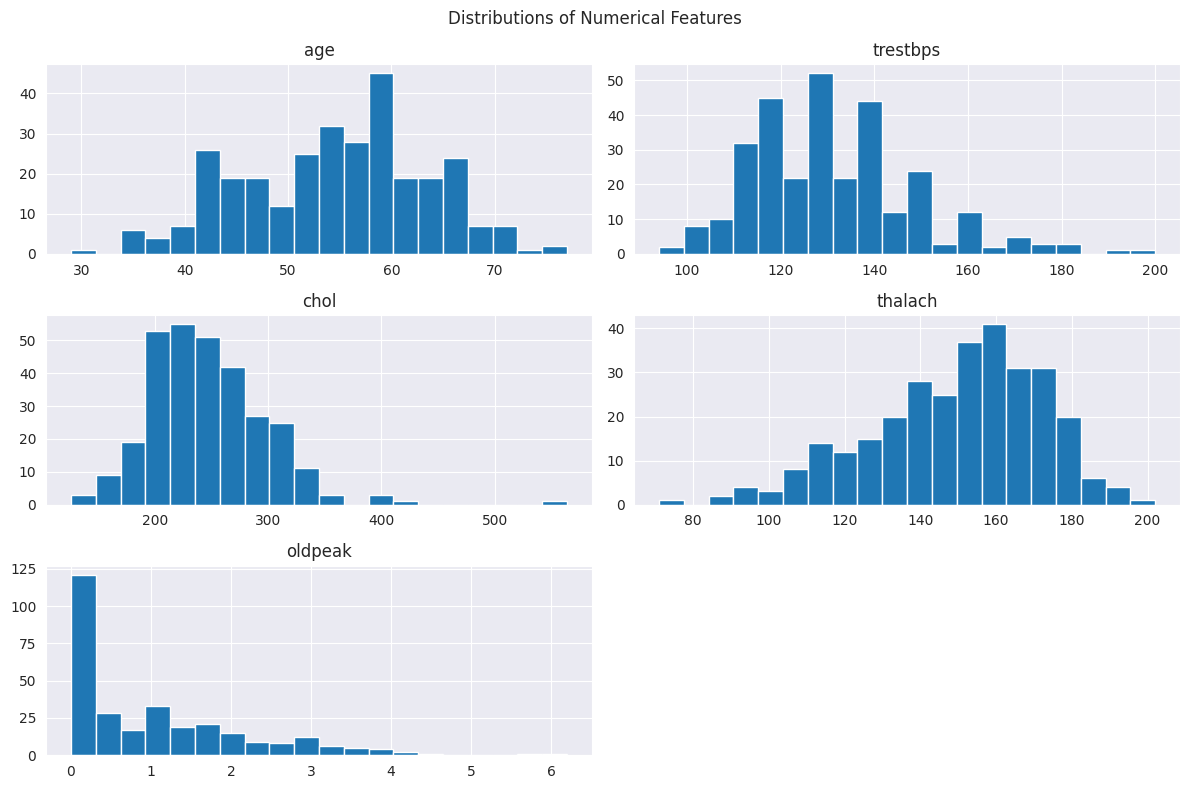

In [33]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

df[numerical_cols].hist(figsize=(12,8), bins=20)
plt.suptitle("Distributions of Numerical Features")
plt.tight_layout()
plt.show()

#### Outlier Detection

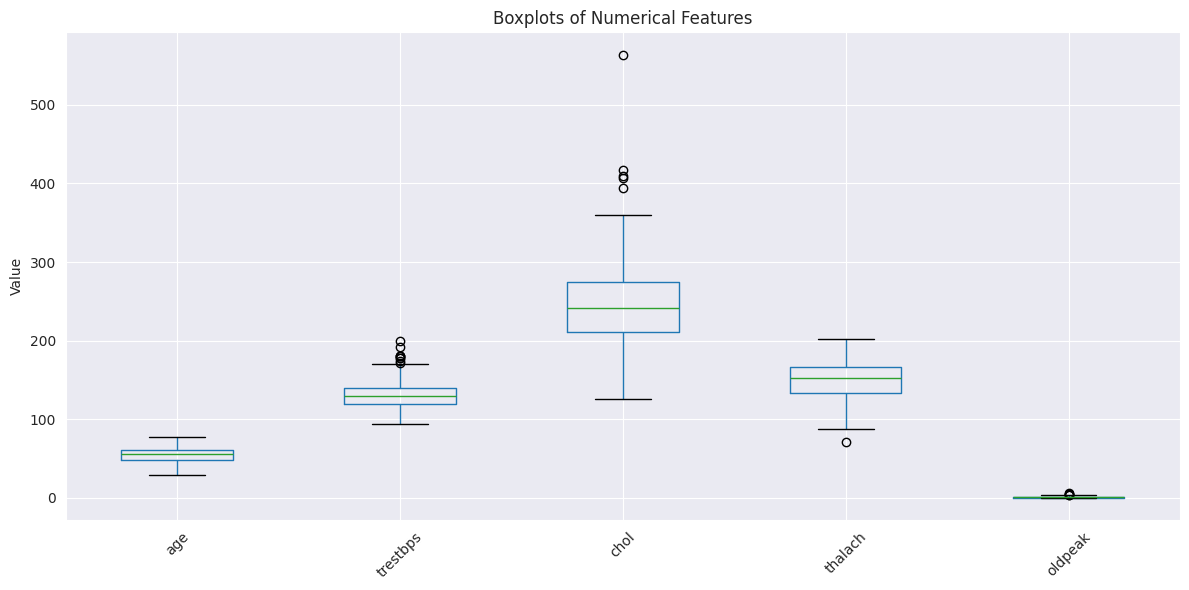

In [34]:
plt.figure(figsize=(12,6))
df[numerical_cols].boxplot()
plt.title("Boxplots of Numerical Features")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Counts of Categorical Features

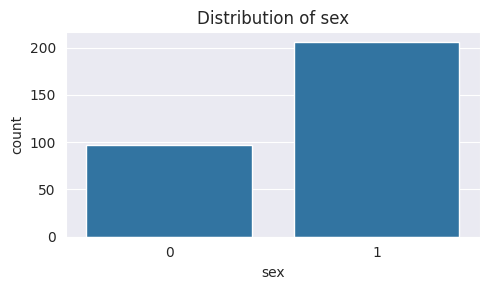

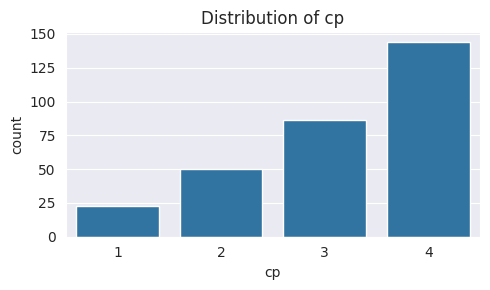

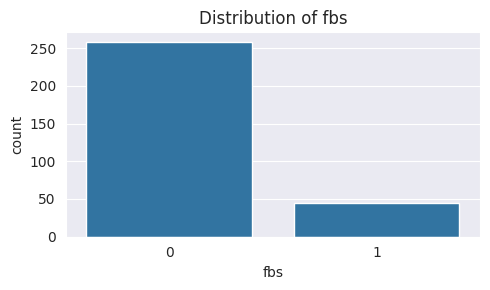

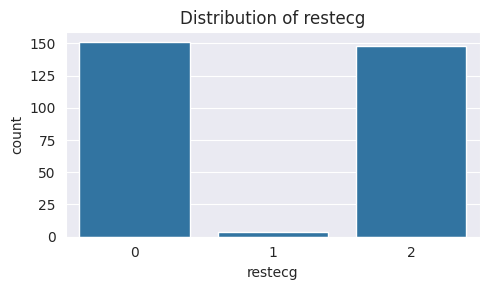

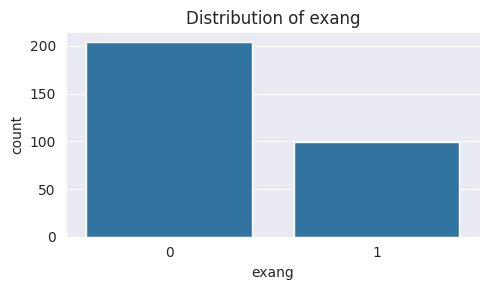

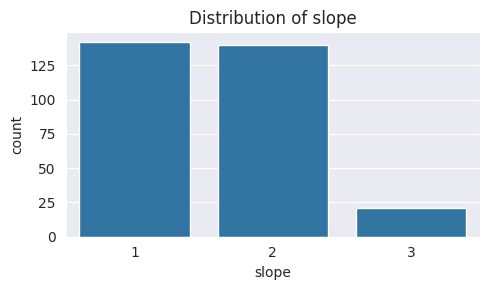

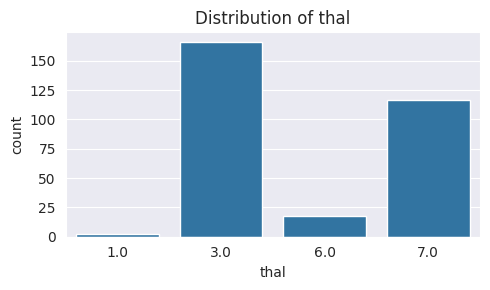

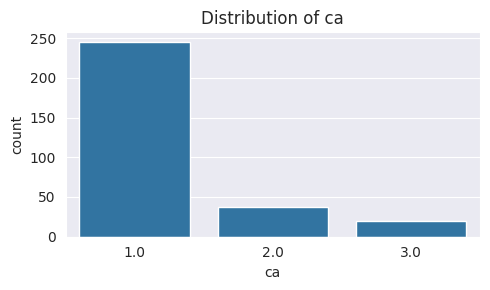

In [35]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']

for col in categorical_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

### Numerical Features vs Target

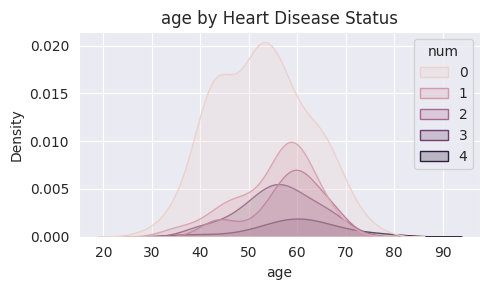

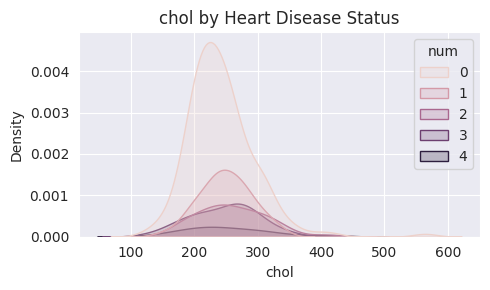

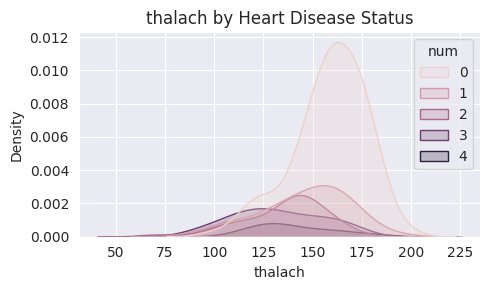

In [37]:
for col in ['age', 'chol', 'thalach']:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df, x=col, hue='num', fill=True)
    plt.title(f'{col} by Heart Disease Status')
    plt.tight_layout()
    plt.show()

#### Categorical Features vs Target

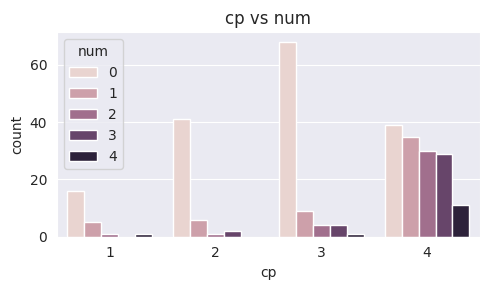

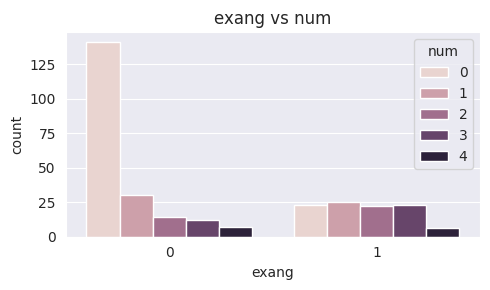

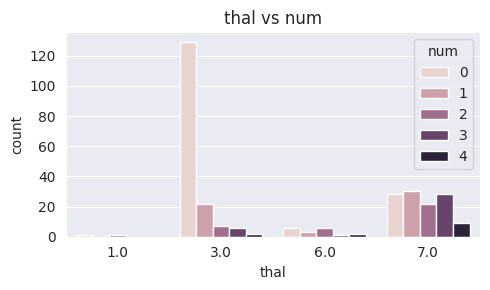

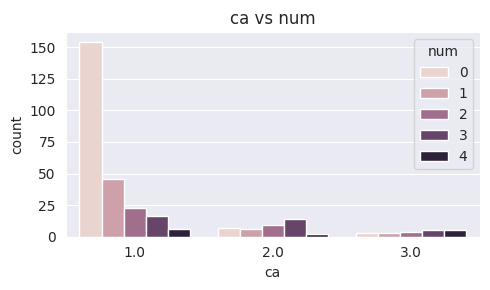

In [39]:
for col in ['cp', 'exang', 'thal', 'ca']:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, hue='num', data=df)
    plt.title(f'{col} vs num')
    plt.tight_layout()
    plt.show()


#### Correlation Matrix and Heatmap

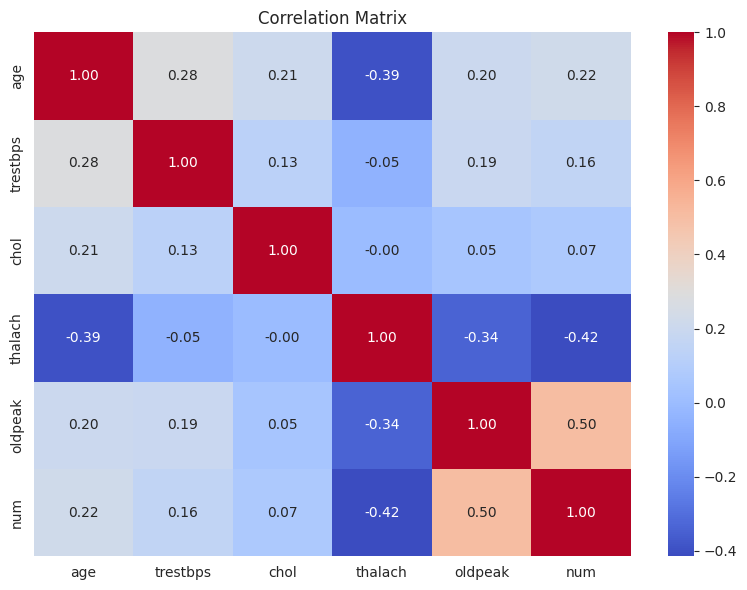

In [40]:
corr = df[numerical_cols + ['num']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [41]:
#### Pairplot

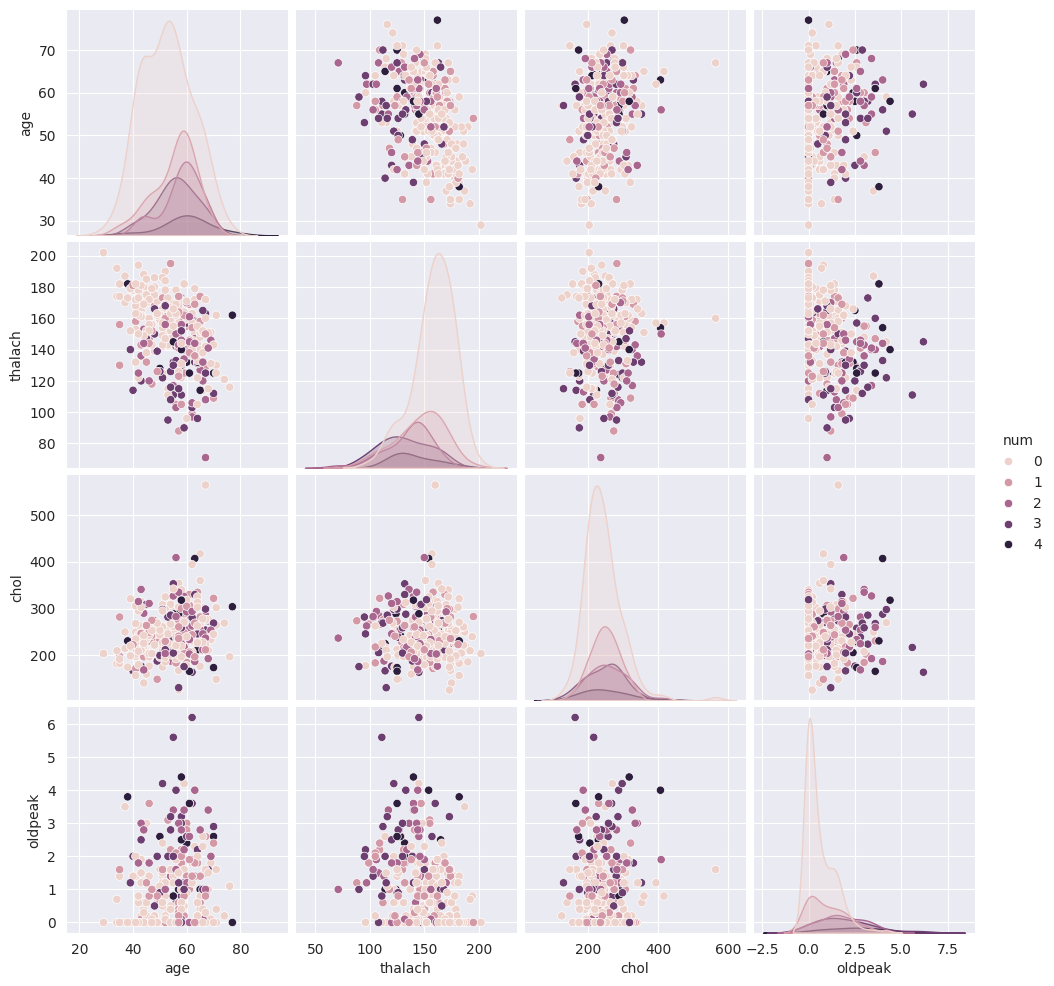

In [43]:
sns.pairplot(
    df[['age', 'thalach', 'chol', 'oldpeak', 'num']],
    hue='num'
)
plt.show()

### T-Test

In [46]:
group0 = df[df['num'] == 0]
group1 = df[df['num'] == 1]

for col in numerical_cols:
    stat, p = ttest_ind(group0[col], group1[col])
    print(f"{col}: p-value = {p:.4f}")

age: p-value = 0.0513
trestbps: p-value = 0.1248
chol: p-value = 0.4128
thalach: p-value = 0.0001
oldpeak: p-value = 0.0016


#### Chi-square Test

In [49]:
contingency = pd.crosstab(df['cp'], df['num'])
chi2, p, dof, exp = chi2_contingency(contingency)
print("Chest Pain vs Target p-value:", p)

Chest Pain vs Target p-value: 7.781947207487869e-14
